In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install slidingwindow --user
!pip3 install tf-slim --user
# !pip install tensorflow-gpu==2.2.0 

In [ ]:
!nvidia-smi

Wed Mar 10 19:24:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# import tensorflow as tf
# print(tf.__version__) # 2.2.0
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/colab/')

import os
import numpy as np

import cv2
from tqdm import tqdm

import math
import time
import collections

import tensorflow as tf

from tf_pose.networks import get_graph_path,model_wh
from tf_pose.estimator_sports import TfPoseEstimator,PoseEstimator
from tf_pose import common

import matplotlib.pyplot as plt


gfile = tf.io.gfile

In [ ]:
from utils import label_map_util
from utils import visualization_utils as vis_util

In [ ]:
# select video

videodir = "/content/drive/MyDrive/LTPTVideos/AFL Video/181101_AFL-PEORIA_AFL-SCOTTSDALE__0/"
videoname = "3371A" #"3367C","3370B","3387B","3390B"
videopath = os.path.join(videodir, videoname + ".mp4")
views={"A":2,"B":2,"C":1}
view=videoname[-1] # B or C

In [ ]:
## video setting
nhumans= views[view]
padding=5 #default:0

resolution="432x368"
show_process=False
resize_out_ratio= 4.0# default:4.0
showBG=True
w, h = 432, 368

In [ ]:
## load frames
cap = cv2.VideoCapture(videopath)
images_all=[]
bgimages_all=[]
while True:
    ret_val, image = cap.read()
    if not ret_val: 
        break
    img=cv2.resize(image, (w,h), interpolation=cv2.INTER_CUBIC)
    bgimg=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images_all.append(img)
    bgimages_all.append(bgimg)
images_all=np.stack(images_all,axis=0)
nframes=len(images_all)

In [ ]:
nframes 


351

In [ ]:
## Segment frames by bbox
# def run_inference_for_minibatch_images(images, graph):
#     """
#     images: numpy.array- B*H *W *C
#     """
#     with graph.as_default():
#         with tf.compat.v1.Session() as sess:
#             ops = tf.compat.v1.get_default_graph().get_operations()
#             all_tensor_names = {output.name for op in ops for output in op.outputs}
#             tensor_dict = {}
#             for key in [
#                 'num_detections', 'detection_boxes', 'detection_scores',
#                 'detection_classes', 'detection_masks'
#             ]:
#                 tensor_name = key + ':0'
#                 if tensor_name in all_tensor_names:
#                     tensor_dict[key] = tf.compat.v1.get_default_graph().get_tensor_by_name(tensor_name)
#             image_tensor = tf.compat.v1.get_default_graph().get_tensor_by_name('image_tensor:0')

#             # Run inference
#             output_dict = sess.run(tensor_dict,
#                                    feed_dict={image_tensor: images})
#     return output_dict

In [ ]:
def valid_boxes_on_minibatch_images(boxes, classes, scores, max_boxes_to_draw, min_score_thresh, selected_class=None):
    valid_output = {}
    b = boxes.shape[0]

    minibatch_boxes = []
    minibatch_scores = []
    minibatch_classes = []
    for i in range(b):
        single_boxes = []
        single_scores = []
        single_classes = []
        for j in range(min(max_boxes_to_draw, boxes.shape[1])):
            if scores[i][j] > min_score_thresh and (not selected_class or classes[i][j] == selected_class):
                ymin, xmin, ymax, xmax = boxes[i][j]
                (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
                single_boxes.append([left, right, top, bottom])
                single_scores.append(scores[i][j])  
                single_classes.append(classes[i][j])
        minibatch_boxes.append(single_boxes)
        minibatch_scores.append(single_scores)
        minibatch_classes.append(single_classes)
    return minibatch_boxes, minibatch_scores, minibatch_classes

In [ ]:
def filter_boxes_on_minibatch_images(boxes, classes, scores, max_boxes_to_draw=2, min_score_thresh=0.3):
    b = len(boxes)

    players_boxes = []
    players_scores = []
    players_classes = []

    for i in range(b):
        player_boxes = []
        player_scores = []
        player_classes = []
        candi=[]
        for j in range(len(boxes[i])):
            if scores[i][j] > min_score_thresh:
                left, right, top, bottom = boxes[i][j]
                area=(right-left)*(bottom-top)
                if 0<area<0.25:
                    candi.append((j,area))
        candi=sorted(candi,key=lambda x:x[1],reverse=True)

        for t in range(min(max_boxes_to_draw,len(candi))):
            idx,_=candi[t]
            left, right, top, bottom = boxes[i][idx]
            player_boxes.append([left, right, top, bottom])
            player_scores.append(scores[i][idx])
            player_classes.append(classes[i][idx])

        players_boxes.append(player_boxes)
        players_scores.append(player_scores)
        players_classes.append(player_classes)

    return players_boxes, players_scores, players_classes

In [ ]:
## tf1 object detection

# MODEL_NAME =  'ssd_inception_v2_coco_2018_01_28' 
# PATH_TO_FROZEN_GRAPH = '/content/drive/MyDrive/colab/data/' + MODEL_NAME + '/frozen_inference_graph.pb'
# data_label='mscoco_label_map.pbtxt'
# PATH_TO_LABELS = os.path.join("/content/drive/MyDrive/colab/data", data_label)
# category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

# detection_graph = tf.Graph()
# with detection_graph.as_default():
#     od_graph_def = tf.compat.v1.GraphDef()
#     with gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
#         serialized_graph = fid.read()
#         od_graph_def.ParseFromString(serialized_graph)
#         tf.import_graph_def(od_graph_def, name='')



In [ ]:
## tf2 object detection

model_name= "ssd_mobilenet_v2_320x320_coco17_tpu-8"  
start_time = time.time()
tf.keras.backend.clear_session()
model_dir="/content/drive/MyDrive/colab/data/" 

detect_fn = tf.saved_model.load(model_dir+model_name+'/saved_model/')

end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 20.090519666671753s


In [ ]:
# def object_detection_on_video(images,BATCH=20,max_boxes=20,min_score=0.3):
#     nframes=len(images)
#     nbatch = nframes // BATCH + (1 if nframes % BATCH > 0 else 0)   

#     players_boxes = []
#     players_scores = []
#     players_classes = []

#     start=time.time()


#     # with detection_graph.as_default():
#     #     with tf.compat.v1.Session() as sess:
#     #         ops = tf.compat.v1.get_default_graph().get_operations()
#     #         all_tensor_names = {output.name for op in ops for output in op.outputs}
#     #         tensor_dict = {}
#     #         for key in [
#     #             'num_detections', 'detection_boxes', 'detection_scores',
#     #             'detection_classes', 'detection_masks'
#     #         ]:
#     #             tensor_name = key + ':0'
#     #             if tensor_name in all_tensor_names:
#     #                 tensor_dict[key] = tf.compat.v1.get_default_graph().get_tensor_by_name(tensor_name)
#     #         image_tensor = tf.compat.v1.get_default_graph().get_tensor_by_name('image_tensor:0')

#     #         # Run inference
#     #         output_dict = sess.run(tensor_dict,
#     #                                 feed_dict={image_tensor: images[:20]})

#     for j in tqdm(range(nbatch)):
#         idx_st = j * BATCH
#         idx_ed = (j + 1) * BATCH if (j + 1) * BATCH < nframes else nframes
#         image_batch = images[idx_st:idx_ed]  # B*H*W*C
#         output_dict = run_inference_for_minibatch_images(image_batch, detection_graph)

#         valid_boxes, valid_scores, valid_classes = valid_boxes_on_minibatch_images(
#             output_dict['detection_boxes'],
#             output_dict['detection_classes'],
#             output_dict['detection_scores'],
#             max_boxes,
#             min_score,
#             selected_class=1
#         )

#         minibatch_boxes, minibatch_scores, minibatch_classes = filter_boxes_on_minibatch_images(
#             valid_boxes,
#             valid_classes,
#             valid_scores,
#             max_boxes_to_draw=nhumans # default:2
#         ) 

#         players_boxes += minibatch_boxes
#         players_scores += minibatch_scores
#         players_classes += minibatch_classes  
    
#     end=time.time()
#     elapsed_time = end - start
#     print('elapse time on tf1 model',elapsed_time)
#     return players_boxes, players_scores, players_classes

In [ ]:
# players_boxes, players_scores, players_classes=object_detection_on_video(bgimages_all)

# elapsed_time=object_detection_on_video(bgimages_all)
# print('elapse time on tf1 model',elapsed_time)

In [ ]:
def object_detection_on_video_tf2(images,BATCH=20,max_boxes=20,min_score=0.3):
    nframes=len(images)

    players_boxes = []
    players_scores = []
    players_classes = []

    start=time.time()

    for j in tqdm(range(nframes)):
        input_tensor = np.expand_dims(images[j], 0)
        output_dict = detect_fn(input_tensor)

        valid_boxes, valid_scores, valid_classes = valid_boxes_on_minibatch_images(
              output_dict['detection_boxes'],
              output_dict['detection_classes'],
              output_dict['detection_scores'],
              max_boxes,
              min_score,
              selected_class=1
          )
      

        minibatch_boxes, minibatch_scores, minibatch_classes = filter_boxes_on_minibatch_images(
              valid_boxes,
              valid_classes,
              valid_scores,
              max_boxes_to_draw=nhumans # default:2
          ) 
        
        players_boxes+=minibatch_boxes
        players_scores+=minibatch_scores
        players_classes+=minibatch_classes
    
    end=time.time()
    elapsed_time = end - start
    print('elapse time on tf2 model',elapsed_time)
    return players_boxes, players_scores, players_classes

In [ ]:
players_boxes, players_scores, players_classes=object_detection_on_video_tf2(bgimages_all)
# print('elapse time on tf2 model',elapsed_time)

players_boxes=np.array(players_boxes)
players_scores=np.array(players_scores)
players_classes=np.array(players_classes)

100%|██████████| 351/351 [01:08<00:00,  5.11it/s]


elapse time on tf2 model 68.67247319221497


In [ ]:
players_boxes.shape

(351, 2, 4)

In [ ]:
data_label='mscoco_label_map.pbtxt'
PATH_TO_LABELS = os.path.join("/content/drive/MyDrive/colab/data", data_label)
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)


def visualize_ordered_boxes_and_labels_on_image_array(
        image,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=False,
        max_boxes_to_draw=20,
        min_score_thresh=0.0,
        agnostic_mode=False,
        line_thickness=4,
        groundtruth_box_visualization_color='black',
        skip_scores=False,
        skip_labels=False):
    # Create a display string (and color) for every box location, group any boxes
    # that correspond to the same location.
    categorical_colors = ['darkorchid', 'mediumorchid', 'violet', 'plum', 'mediumpurple',
                          'royalblue', 'deepskyblue', 'darkturquoise', 'paleturquoise', 'mediumspringgreen',
                          'lightseagreen', 'seagreen', 'olivedrab', 'darkkhaki', 'gold',
                          'moccasin', 'orange', 'darkorange', 'coral', 'orangered']  # 20

    box_to_display_str_map = collections.defaultdict(list)
    box_to_color_map = collections.defaultdict(str)
    if not max_boxes_to_draw:
        max_boxes_to_draw = len(boxes)
    for i in range(min(max_boxes_to_draw, len(boxes))):
        if scores is None or scores[i] > min_score_thresh:
            box = tuple(boxes[i])
            if scores is None:
                box_to_color_map[box] = groundtruth_box_visualization_color
            else:
                display_str = ''
            if not skip_labels:
                if not agnostic_mode:
                    if classes[i] in category_index.keys():
                        class_name = category_index[classes[i]]['name']
                    else:
                        class_name = 'N/A'
                    display_str = str(class_name)
            if not skip_scores:
                if not display_str:
                    display_str = '{}%'.format(int(100 * scores[i]))
                else:
                    display_str = '{}: {}%'.format(display_str, int(100 * scores[i]))

            box_to_display_str_map[box].append(display_str)
            if agnostic_mode:
                box_to_color_map[box] = 'DarkOrange'
            else:
                box_to_color_map[box] = categorical_colors[i]

    # Draw all boxes onto image.
    for box, color in box_to_color_map.items():
        left, right, top, bottom = box
        ymin, xmin, ymax, xmax = top, left, bottom, right
        vis_util.draw_bounding_box_on_image_array(
            image,
            ymin,
            xmin,
            ymax,
            xmax,
            color=color,
            thickness=line_thickness,
            display_str_list=box_to_display_str_map[box],
            use_normalized_coordinates=use_normalized_coordinates)

    return image

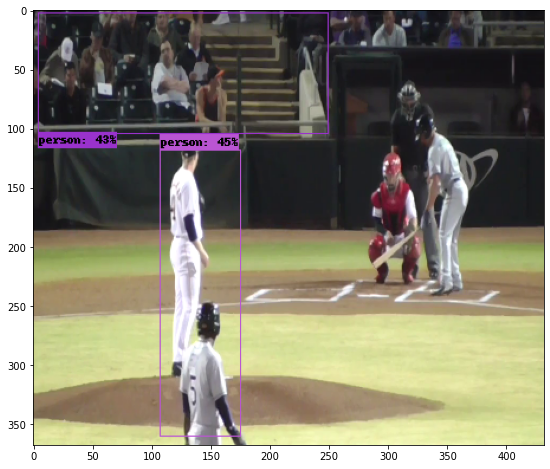

In [ ]:
## plot bbox
%matplotlib inline
IMAGE_SIZE = (12, 8)

idx=6
image=bgimages_all[idx].copy()
visualize_ordered_boxes_and_labels_on_image_array(
    image,
    players_boxes[idx],
    players_classes[idx],
    players_scores[idx],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=2,  # view B:2, view C"3
    min_score_thresh=0.3,
    line_thickness=1,
    )

fig, ax = plt.subplots(figsize=IMAGE_SIZE)
ax.imshow(image)
plt.show()
# plt.close()

In [ ]:
## pad object detection bbox
def bbox_padding(players_boxes,padding):
    nframes=len(players_boxes)
    new_boxes=[]
    oh, ow=h//2, w//2   
    for i in tqdm(range(nframes)):
        tmp_box = []
        for j in range(len(players_boxes[i])):
            left, right, top, bottom = players_boxes[i][j]
            gl, gr, gt, gb = left * ow, right * ow, top * oh, bottom * oh
            gl, gr, gt, gb = max(gl - padding, 0), min(gr + padding, ow), max(gt - padding, 0), min(gb + padding, oh)
            tmp_box.append([gl / ow, gr / ow, gt / oh, gb / oh])
        new_boxes.append(tmp_box) 
    return new_boxes

In [ ]:
new_boxes=bbox_padding(players_boxes,padding)

100%|██████████| 351/351 [00:00<00:00, 17746.34it/s]


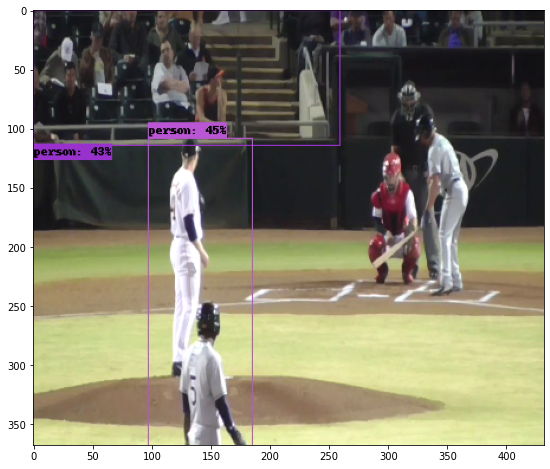

In [ ]:
## plot bbox
%matplotlib inline

IMAGE_SIZE = (12, 8)

idx=6
image=bgimages_all[idx].copy()
visualize_ordered_boxes_and_labels_on_image_array(
    image,
    new_boxes[idx],
    players_classes[idx],
    players_scores[idx],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=2,  # view B:2, view C"3
    min_score_thresh=0.3,
    line_thickness=1,
    )

fig, ax = plt.subplots(figsize=IMAGE_SIZE)
ax.imshow(image)
plt.show()


In [ ]:
## compute mask
def image_mask(players_boxes):
    oh, ow=h//2, w//2
    nframes=len(players_boxes)
    obj_mask = np.zeros((nframes, oh, ow))

    for i in tqdm(range(nframes)):
        for j in range(len(players_boxes[i])):
            left, right, top, bottom = players_boxes[i][j]
            gl, gr, gt, gb = math.floor(left * ow), math.ceil(right * ow), math.floor(top * oh), math.ceil(bottom * oh)
            obj_mask[i,gt:gb,gl:gr].fill(1)
    return obj_mask


In [ ]:
obj_mask=image_mask(new_boxes)

100%|██████████| 351/351 [00:00<00:00, 38635.37it/s]


In [ ]:
## pose estimation on single image
def pose_estimation_with_mask(images,obj_mask,model="mobilenet_thin"):

    e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))
    nframes=len(obj_mask)

    humans_video=[]
    for t in tqdm(range(nframes)):
        image=images[t]
        peaks,heatMat_up,pafMat_up = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)

        idx_mask=np.where(obj_mask[t]<1)
        peaks[idx_mask]=0
        heatMat_up[idx_mask]=0
        pafMat_up[idx_mask]=0

        humans = PoseEstimator.estimate_paf(peaks, heatMat_up, pafMat_up)
        humans_video.append(humans)
    return humans_video


In [ ]:
humans_video=pose_estimation_with_mask(images_all,obj_mask)

[2021-03-10 19:29:08,775] [TfPoseEstimator] [INFO] loading graph from /content/drive/MyDrive/colab/models/graph/mobilenet_thin/graph_opt.pb(default size=432x368)
2021-03-10 19:29:08,775 INFO loading graph from /content/drive/MyDrive/colab/models/graph/mobilenet_thin/graph_opt.pb(default size=432x368)
100%|██████████| 351/351 [00:09<00:00, 37.04it/s]


In [ ]:
def draw_humans(npimg, humans, imgcopy=False):
    if imgcopy:
        npimg = np.copy(npimg)
    image_h, image_w = npimg.shape[:2]
    centers = {}
    for human in humans:
        # draw point
        for i in range(common.CocoPart.Background.value):
            if i not in human.body_parts.keys():
                continue

            body_part = human.body_parts[i]
            center = (int(body_part.x * image_w + 0.5), int(body_part.y * image_h + 0.5))
            centers[i] = center
            cv2.circle(npimg, center, 3, common.CocoColors[i], thickness=3, lineType=8, shift=0)

        # draw line
        for pair_order, pair in enumerate(common.CocoPairsRender):
            if pair[0] not in human.body_parts.keys() or pair[1] not in human.body_parts.keys():
                continue
            cv2.line(npimg, centers[pair[0]], centers[pair[1]], common.CocoColors[pair_order], 3)
    return npimg

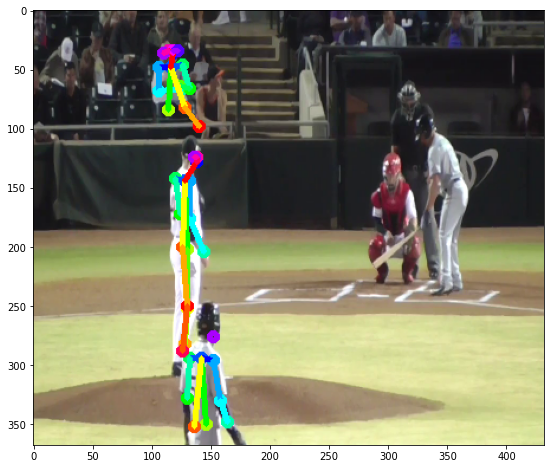

In [ ]:
%matplotlib inline

IMAGE_SIZE = (12, 8)

idx=6
img=images_all[idx]
humans=humans_video[idx]
drawn_skeleton= draw_humans(img, humans, imgcopy=False)
drawn_skeleton = cv2.cvtColor(drawn_skeleton, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(figsize=IMAGE_SIZE)
ax.imshow(drawn_skeleton)
plt.show()


In [ ]:
## parse pose estimation
nframes=len(humans_video)
nhumans=2

kps_all=[]
for i in range(nframes):
    frame_humans=[]
    for j in range(len(humans_video[i])):
        kps=humans_video[i][j].body_parts.keys()
        # print(i,j,len(list(kps)))
        single_human=[]
        for p in kps:
            x,y=humans_video[i][j].body_parts[p].x,humans_video[i][j].body_parts[p].y
            single_human.append((p,[x,y]))
        frame_humans.append(single_human)
    kps_all.append(frame_humans)

In [ ]:
## sort pose estimation

kps_sorted=[]
for i in range(nframes):
    if len(kps_all[i])==1:
        kps_sorted.append(kps_all[i])
        continue

    cxs=[]
    for j in range(len(kps_all[i])):
        cx=np.mean([coor[1][0] for coor in kps_all[i][j]]) #j-th human:cx
        cxs.append(cx)
    lr_order=np.argsort(cxs)
    frame_humans=[]
    for idx in lr_order:
        frame_humans.append(kps_all[i][idx])
    kps_sorted.append(frame_humans)

In [ ]:
## refine pose estimation
kps_valid=[]
for i in range(nframes):
    if len(kps_sorted[i])==nhumans:
        kps_valid.append(kps_sorted[i])
        continue

    ## sort in area
    areas=[]
    centers=[]
    for j in range(len(kps_sorted[i])):
        center=np.mean([coor[1] for coor in kps_sorted[i][j]],axis=0)
        centers.append(center)

        l=np.min([coor[1][0] for coor in kps_sorted[i][j]])
        r=np.max([coor[1][0] for coor in kps_sorted[i][j]])
        t=np.min([coor[1][1] for coor in kps_sorted[i][j]])
        b=np.max([coor[1][1] for coor in kps_sorted[i][j]])
        area=(r-l)*(b-t)
        areas.append(area)
    area_order=np.argsort(areas)[::-1] # max to min

    centers=np.array(centers)

    ## sort in number of kps
    nkps=[len(coors) for coors in kps_sorted[i]]
    ct_order=np.argsort(nkps)[::-1] # max to min

    main_idx=area_order[:nhumans]
    query_idx=area_order[nhumans:]

    # combine humans
    for idx in query_idx:
        single_ct=centers[idx]
        dist=np.linalg.norm(centers[main_idx]-single_ct,axis=1)
        dist_order=main_idx[np.argmin(dist)]

        key_query={}
        for coor in kps_sorted[i][idx]:
            key_query[coor[0]]=coor[1]
        key_main={}
        for coor in kps_sorted[i][dist_order]:
            key_main[coor[0]]=coor[1]

        set_query=set(key_query.keys())
        set_main=set(key_main.keys())

        if len(set_main.intersection(set_query))==0:
            kps_sorted[i][dist_order]+=kps_sorted[i][idx]
        else:
            same=True
            for k in set_main.intersection(set_query):
                if key_query[k]!=key_main[k]:
                    same=False
            if same:
                for k in set_query.difference(set_main):
                    kps_sorted[i][dist_order] += [key_query[k]]
    frame_humans=[]
    for idx in main_idx:
        frame_humans.append(kps_sorted[i][idx])
    kps_valid.append(frame_humans)


In [ ]:
## sort refined pose estimation

kps_valid_sorted = [] # left to right
for i in range(nframes):
    if len(kps_valid[i]) == 1:
        frame_humans = kps_valid[i]
        ## Padding for missing agent after detection
        if len(kps_valid[i])<nhumans:
            for _ in range(nhumans-len(kps_valid[i])):
                frame_humans.append([(idx,[0,0]) for idx in range(18)])
        kps_valid_sorted.append(frame_humans)
        continue

    cxs = []
    for j in range(len(kps_valid[i])):
        cx = np.mean([coor[1][0] for coor in kps_valid[i][j]])  # j-th human:cx
        cxs.append(cx)
    lr_order = np.argsort(cxs)
    frame_humans = []
    for idx in lr_order:
        frame_humans.append(kps_valid[i][idx])
    ## Padding for missing agent after detection
    if len(kps_valid[i])<nhumans:
        for _ in range(nhumans-len(kps_valid[i])):
            frame_humans.append([(idx,[0,0]) for _ in range(18)])
    kps_valid_sorted.append(frame_humans)

In [ ]:
len(kps_valid_sorted)

351

In [ ]:
nhumans

2

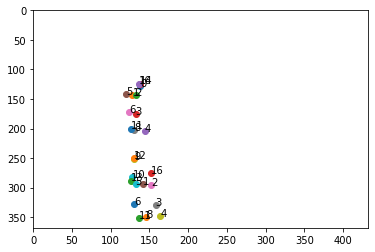

In [ ]:
## keypoints scatter plot after refining
%matplotlib inline
idx=6

fig, ax = plt.subplots()
for j in range(len(kps_valid_sorted[idx])):
    for p ,coor in kps_valid_sorted[idx][j]:
        ax.scatter(coor[0]*w, coor[1]*h)
        ax.annotate(p, (coor[0]*w, coor[1]*h))
plt.xlim([0, w])
plt.ylim([0, h])
plt.gca().invert_yaxis()
plt.show()
plt.close()

In [ ]:
## keypoints
keypoints=[
    ['nose_x','noise_y'],
    ['neck_x','neck_y'],
    ['right_shoulder_x','right_shoulder_y'],
    ['right_elbow_x','right_elbow_y'],
    ['right_wrist_x','right_wrist_y'],
    ['left_shoulder_x','left_should_y'],
    ['left_elbow_x','left_elbow_y'],
    ['left_wrist_x','left_wrist_y'],
    ['right_hip_x','right_hip_y'],
    ['right_knee_x','right_knee_y'],
    ['right_ankle_x','right_ankle_y'],
    ['left_hip_x','left_hip_y'],
    ['left_knee_x','left_knee_y'],
    ['left_ankle_x','left_ankle_y'],
    ['right_eye_x','right_eye_y'],
    ['left_eye_x','left_eye_y'],
    ['right_ear_x','right_ear_y'],
    ['left_ear_x','left_ear_y']
]

In [ ]:
## save keypoints into dict
from collections import defaultdict

nframes=len(kps_valid_sorted)

kps_dict={}
for j in range(nhumans):
    key_agent='Agent{:d}'.format(j+1)
    kps_dict[key_agent]=defaultdict(list)
    for i in range(nframes):
          missed=set([x[0] for x in keypoints]+[x[1] for x in keypoints])
          for idx ,coor in kps_valid_sorted[i][j]:
              kps=keypoints[idx]
              kps_dict[key_agent][kps[0]].append(coor[0]) # x coordinate
              kps_dict[key_agent][kps[1]].append(coor[1]) # y coordinate
              missed.remove(kps[0])
              missed.remove(kps[1])
          for kps in missed:
              kps_dict[key_agent][kps].append(0) # x coordinate          


In [ ]:
kps_valid_sorted[262]

[[(1, [0.3194444444444444, 0.5108695652173914]),
  (2, [0.3611111111111111, 0.4891304347826087]),
  (3, [0.41203703703703703, 0.44565217391304346]),
  (4, [0.4212962962962963, 0.41847826086956524]),
  (5, [0.28703703703703703, 0.5217391304347826]),
  (6, [0.2777777777777778, 0.5978260869565217]),
  (7, [0.2777777777777778, 0.6195652173913043]),
  (8, [0.3425925925925926, 0.625]),
  (9, [0.3472222222222222, 0.7282608695652174]),
  (10, [0.3472222222222222, 0.8097826086956522]),
  (11, [0.30092592592592593, 0.625]),
  (12, [0.32407407407407407, 0.7282608695652174]),
  (13, [0.33796296296296297, 0.8097826086956522]),
  (16, [0.3194444444444444, 0.45652173913043476]),
  (17, [0.2962962962962963, 0.4673913043478261])],
 [(0, [0, 0]),
  (1, [0, 0]),
  (2, [0, 0]),
  (3, [0, 0]),
  (4, [0, 0]),
  (5, [0, 0]),
  (6, [0, 0]),
  (7, [0, 0]),
  (8, [0, 0]),
  (9, [0, 0]),
  (10, [0, 0]),
  (11, [0, 0]),
  (12, [0, 0]),
  (13, [0, 0]),
  (14, [0, 0]),
  (15, [0, 0]),
  (16, [0, 0]),
  (17, [0, 0])

In [ ]:
len(kps_dict['Agent1']['nose_y'])

0

In [ ]:
output_filename = os.path.join("/content/drive/MyDrive/colab/results", '{}_skeleton_dict_pad{:02d}.npy'.format(videoname, padding))
with open(output_filename, 'wb') as file:
    np.save(file, kps_dict)
